In [24]:
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import gym
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal
from torch.nn.utils import clip_grad_norm_
import torch.optim as optim

In [81]:

BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-2            # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0#1e-2        # L2 weight decay


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256, init_w=3e-3, log_std_min=-20, log_std_max=2):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        
        self.mu = nn.Linear(hidden_size, action_size)
        self.log_std_linear = nn.Linear(hidden_size, action_size)

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.mu.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mu(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        return mu, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mu, log_std = self.forward(state)
        std = log_std.exp()
        
        dist = Normal(0, 1)
        e = dist.sample().to(device)
        action = torch.tanh(mu + e * std)
        log_prob = Normal(mu, std).log_prob(mean + e * std) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob
        
    
    def get_action(self, state):
        """
        returns the action based on a squashed gaussian policy. That means the samples are obtained according to:
        a(s,e)= tanh(mu(s)+sigma(s)+e)
        """
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mu, log_std = self.forward(state)
        std = log_std.exp()
        
        dist = Normal(0, 1)
        e      = dist.sample().to(device)
        action = torch.tanh(mu + e * std).cpu()
        return action[0]


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, hidden_size=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            hidden_size (int): Number of nodes in the network layers

        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size+action_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, action_prior="uniform"):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        
        self.target_entropy = -action_size  # -dim(A)
        self.alpha = 1
        self.log_alpha = torch.tensor([0.0], requires_grad=True)
        self.alpha_optimizer = optim.Adam(params=[self.log_alpha], lr=LR_ACTOR) 
        self._action_prior = action_prior
        
        print("Using: ", device)
        
        # Actor Network 
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)     
        
        # Critic Network (w/ Target Network)
        self.critic1 = Critic(state_size, action_size, random_seed).to(device)
        self.critic2 = Critic(state_size, action_size, random_seed).to(device)
        
        self.critic1_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic1_target.load_state_dict(self.critic1.state_dict())

        self.critic2_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic2_target.load_state_dict(self.critic2.state_dict())

        self.critic1_optimizer = optim.Adam(self.critic1.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        self.critic2_optimizer = optim.Adam(self.critic2.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY) 

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        

    def step(self, state, action, reward, next_state, done, step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(step, experiences, GAMMA)
            
    
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).unsqueeze(0).float().to(device)
        action = self.actor_local.get_action(state).detach()
        return action

    def learn(self, step, experiences, gamma, d=1):
        """Updates actor, critics and entropy_alpha parameters using given batch of experience tuples.
        Q_targets = r + γ * (min_critic_target(next_state, actor_target(next_state)) - α *log_pi(next_action|next_state))
        Critic_loss = MSE(Q, Q_target)
        Actor_loss = α * log_pi(a|s) - Q(s,a)
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        next_action, log_pis_next = self.actor_local.evaluate(next_states)

        Q_target1_next = self.critic1_target(next_states.to(device), next_action.squeeze(0).to(device))
        Q_target2_next = self.critic2_target(next_states.to(device), next_action.squeeze(0).to(device))

        # take the mean of both critics for updating
        Q_target_next = torch.min(Q_target1_next, Q_target2_next)

        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * (1 - dones) * (Q_target_next - self.alpha * log_pis_next.squeeze(0)))

        # Compute critic loss
        Q_1 = self.critic1(states, actions)
        Q_2 = self.critic2(states, actions)
        critic1_loss = 0.5*F.mse_loss(Q_1, Q_targets.detach())
        critic2_loss = 0.5*F.mse_loss(Q_2, Q_targets.detach())
        # Update critics
        # critic 1
        self.critic1_optimizer.zero_grad()
        critic1_loss.backward()
        self.critic1_optimizer.step()
        # critic 2
        self.critic2_optimizer.zero_grad()
        critic2_loss.backward()
        self.critic2_optimizer.step()
        if step % d == 0:
        # ---------------------------- update actor ---------------------------- #
            
            alpha = torch.exp(self.log_alpha)
            # Compute alpha loss
            actions_pred, log_pis = self.actor_local.evaluate(states)
            alpha_loss = - (self.log_alpha * (log_pis + self.target_entropy).detach()).mean()
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            
            self.alpha = alpha
            # Compute actor loss
            if self._action_prior == "normal":
                policy_prior = MultivariateNormal(loc=torch.zeros(self.action_size), scale_tril=torch.ones(self.action_size).unsqueeze(0))
                policy_prior_log_probs = policy_prior.log_prob(actions_pred)
            elif self._action_prior == "uniform":
                policy_prior_log_probs = 0.0
       
            actor_loss = (alpha * log_pis.squeeze(0) - self.critic1(states, actions_pred.squeeze(0)) - policy_prior_log_probs ).mean()

            # Minimize the loss
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()

            # ----------------------- update target networks ----------------------- #
            self.soft_update(self.critic1, self.critic1_target, TAU)
            self.soft_update(self.critic2, self.critic2_target, TAU)
                     

    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [85]:
def SAC(n_episodes=200, max_t=500, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []
    minmax_scores = []
    average_100_scores = []

    for i_episode in range(1, n_episodes+1):

        state = env.reset()
        score = 0
        for t in range(max_t):
            
            action = agent.act(state)
            next_state, reward, done, info = env.step(action[0].numpy())
            agent.step(state, action, reward, next_state, done, t)
            state = next_state
            score += reward

            if done:
                break 
        
        scores_deque.append(score)
        scores.append(score)
        average_100_scores.append(np.mean(scores_deque))
        
        print('\rEpisode {} Reward: {:.2f}  Average100 Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}  Reward: {:.2f}  Average100 Score: {:.2f}'.format(i_episode, score, np.mean(scores_deque)))
        if np.mean(scores_deque) >= - 400:
            print("\nSolved Environment!")
            #torch.save(agent.actor_local.state_dict(), 'final_actor.pth')
            #torch.save(agent.critic_local.state_dict(), 'final_critic.pth')
            break
    return scores, average_100_scores

env = gym.make("Pendulum-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, action_prior="uniform") #"normal"


scores, average_100 = SAC(n_episodes=100, max_t=1000, print_every=10)
env.close()

Using:  cpu
Episode 10  Reward: -963.91  Average100 Score: -1176.28
Episode 20  Reward: -247.34  Average100 Score: -920.285
Episode 30  Reward: -362.19  Average100 Score: -755.52
Episode 40  Reward: -125.20  Average100 Score: -608.97
Episode 50  Reward: -123.95  Average100 Score: -533.25
Episode 60  Reward: -119.65  Average100 Score: -472.77
Episode 70  Reward: -490.85  Average100 Score: -450.08
Episode 80  Reward: -122.12  Average100 Score: -430.26
Episode 90  Reward: -239.08  Average100 Score: -409.16
Episode 95 Reward: -241.00  Average100 Score: -399.10
Solved Environment!


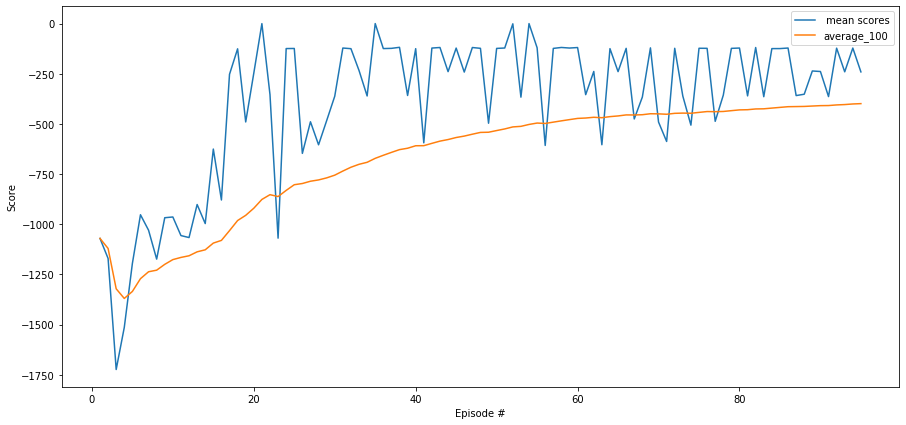

In [86]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label = " mean scores")
plt.plot(np.arange(1, len(average_100)+1), average_100, label = "average_100")
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()